### 1. Libraries Import

In [1]:
import os, json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.datasets import make_regression
sns.set()
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from group_lasso import LogisticGroupLasso
from group_lasso.utils import extract_ohe_groups
import statsmodels.api as sm

from imblearn.over_sampling import RandomOverSampler


### 2. Data Import

In [2]:
datadir = "../data"
outdir = "../output_reports"
outdir_graph = "../figures"
data = os.path.join(datadir, "NSDUH_2023_subset_raw.csv")

variables_used = [
    # Survey design variables 
    "ANALWT2_C", "VESTR_C", "VEREP",
    # Primary outcomes
    "SUTRTPY", "MHTRTPY",
    # Secondary (telehealth) outcomes
    "TELEAPTYR", "IRSUTPHVID", "IRMHTPHVID",
    # Demographic predictors
    "CATAG6", "IRSEX", "NEWRACE2",
    # Socioeconomic predictors
    "IRMARIT", "IREDUHIGHST2", "IRWRKSTAT18",
    "IRINSUR4", "INCOME",
    # Clinical severity predictors
    "IRPYUD5ALC", "IRPYUD5MRJ", "KSSLR6YR",
    # Behavioral predictors
    "IRALCFY", "IRMJFY", "ILLYR",
    # Risk perception predictors
    "RSKCIGPKD", "RSKMRJWK"
]

df_og = pd.read_csv(data, usecols = variables_used, dtype=str)

### 3. Data Cleaning & Remapping

In [3]:
# Simple yes/no in 0/1 form
binary_map_01 = {"0": "No", "1": "Yes"}

# Age (CATAG6)
age_map = {
    "1": "12-17",
    "2": "18-25",
    "3": "26-34",
    "4": "35-49",
    "5": "50-64",
    "6": "65+"
}

# Sex at birth (IRSEX)
sex_map = {"1":"Male","2":"Female"}

race_map = {
    "1": "Non-Hispanic White",
    "2": "Non-Hispanic Black/African American",
    "3": "Non-Hispanic Native American/Alaska Native",
    "4": "Non-Hispanic Native Hawaiian/Other Pacific Islander",
    "5": "Non-Hispanic Asian",
    "6": "Non-Hispanic more than one race",
    "7": "Hispanic"
}

# Family income (INCOME)
income_map = {
    "1":"< $20,000",
    "2":"$20,000-$49,999",
    "3":"$50,000-$74,999",
    "4":"$75,000+"
}

df = df_og.copy()

# Convert survey design variables to numeric
df["ANALWT2_C"] = pd.to_numeric(df["ANALWT2_C"], errors="coerce")
df["VESTR_C"]   = pd.to_numeric(df["VESTR_C"], errors="coerce")
df["VEREP"]     = pd.to_numeric(df["VEREP"], errors="coerce")

df["SUTRTPY_lbl"] = df["SUTRTPY"].map(binary_map_01)
# Convert to numeric for modeling
df["SUTRTPY"] = pd.to_numeric(df["SUTRTPY"], errors="coerce")

df["MHTRTPY_lbl"] = df["MHTRTPY"].map(binary_map_01)
# Convert to numeric for modeling
df["MHTRTPY"] = pd.to_numeric(df["MHTRTPY"], errors="coerce")

# Create a labeled version
df["TELEAPTYR_lbl"] = df["TELEAPTYR"].map({
    "1": "Yes",
    "2": "No",
    "85": "Bad data",
    "94": "Don't know",
    "97": "Refused",
    "98": "Blank"
})

# Convert to numeric (1 = Yes, 0 = No, NaN for all nonresponse codes)
df["TELEAPTYR"] = df["TELEAPTYR"].replace({
    "1": 1,
    "2": 0,
    "85": np.nan,
    "94": np.nan,
    "97": np.nan,
    "98": np.nan
}).astype("float")

df["IRSUTPHVID_lbl"] = df["IRSUTPHVID"].map(binary_map_01)
df["IRSUTPHVID"] = pd.to_numeric(df["IRSUTPHVID"], errors="coerce")

df["IRMHTPHVID_lbl"] = df["IRMHTPHVID"].map(binary_map_01)
df["IRMHTPHVID"] = pd.to_numeric(df["IRMHTPHVID"], errors="coerce")

df["CATAG6_lbl"] = df["CATAG6"].map(age_map)
df["CATAG6"] = pd.to_numeric(df["CATAG6"], errors="coerce")

df["IRSEX_lbl"] = df["IRSEX"].map(sex_map)
df["IRSEX"] = pd.to_numeric(df["IRSEX"], errors="coerce")

df["NEWRACE2_lbl"] = df["NEWRACE2"].map(race_map)
df["NEWRACE2"] = pd.to_numeric(df["NEWRACE2"], errors="coerce")

# Create a labeled version
df["IRMARIT_lbl"] = df["IRMARIT"].map({
    "1": "Married",
    "2": "Widowed",
    "3": "Divorced or Separated",
    "4": "Never Been Married",
    "99": "Legitimate skip (<=14 years old)"
})

# Convert to numeric, set skip to NaN
df["IRMARIT"] = df["IRMARIT"].replace({
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "99": np.nan
}).astype("float")

# Create a labeled version
df["IREDUHIGHST2_lbl"] = df["IREDUHIGHST2"].map({
    "1": "Fifth grade or less",
    "2": "Sixth grade",
    "3": "Seventh grade",
    "4": "Eighth grade",
    "5": "Ninth grade",
    "6": "Tenth grade",
    "7": "Eleventh or Twelfth grade, no diploma",
    "8": "High school diploma/GED",
    "9": "Some college credit, no degree",
    "10": "Associate's degree (AA, AS)",
    "11": "College graduate or higher"
})

# Convert to numeric (ordinal: 1–11)
df["IREDUHIGHST2"] = pd.to_numeric(df["IREDUHIGHST2"], errors="coerce")

# Create a labeled version
df["IRWRKSTAT18_lbl"] = df["IRWRKSTAT18"].map({
    "1": "Employed full time",
    "2": "Employed part time",
    "3": "Unemployed",
    "4": "Other (not in labor force)",
    "99": "Legitimate skip (age 12–14)"
})

# Convert to numeric (1–4), recode 99 to NaN
df["IRWRKSTAT18"] = df["IRWRKSTAT18"].replace({
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "99": np.nan
}).astype("float")

df["IRINSUR4_lbl"] = df["IRINSUR4"].map({
    "1": "Yes, covered by health insurance",
    "2": "No, not covered by health insurance"
})

# Convert to numeric (1 = Yes, 0 = No)
df["IRINSUR4"] = df["IRINSUR4"].replace({
    "1": 1,
    "2": 0
}).astype("float")

df["INCOME_lbl"] = df["INCOME"].map(income_map)
df["INCOME"] = pd.to_numeric(df["INCOME"], errors="coerce")

# Convert to numeric (1–3), set '.' (college dorm) to NaN

df["IRPYUD5ALC_lbl"] = df["IRPYUD5ALC"].map(binary_map_01)
df["IRPYUD5ALC"] = pd.to_numeric(df["IRPYUD5ALC"], errors="coerce")

df["IRPYUD5MRJ_lbl"] = df["IRPYUD5MRJ"].map(binary_map_01)
df["IRPYUD5MRJ"] = pd.to_numeric(df["IRPYUD5MRJ"], errors="coerce")

df["KSSLR6YR"] = pd.to_numeric(df["KSSLR6YR"], errors="coerce")
# Ensure values outside 0–24 are treated as missing (paranoid safety)
df.loc[~df["KSSLR6YR"].between(0, 24, inclusive="both"), "KSSLR6YR"] = np.nan

# Create a labeled version
df["IRALCFY_lbl"] = df["IRALCFY"].map({
    "991": "Never used alcohol",
    "993": "No past-year use"
})

# Convert to numeric, treating 991 and 993 as 0 (no use), others keep their day counts
df["IRALCFY"] = df["IRALCFY"].replace({
    "991": 0,
    "993": 0
})
df["IRALCFY"] = pd.to_numeric(df["IRALCFY"], errors="coerce")

# Create a labeled version
df["IRMJFY_lbl"] = df["IRMJFY"].map({
    "991": "Never used marijuana",
    "993": "No past-year use"
})

# Convert to numeric, treating 991 and 993 as 0 (no use), others keep their day counts
df["IRMJFY"] = df["IRMJFY"].replace({
    "991": 0,
    "993": 0
})
df["IRMJFY"] = pd.to_numeric(df["IRMJFY"], errors="coerce")

# Create a labeled version
df["ILLYR_lbl"] = df["ILLYR"].map({
    "0": "Did not use in past year",
    "1": "Used in past year"
})

# Convert to numeric (binary: 0/1)
df["ILLYR"] = df["ILLYR"].replace({
    "0": 0,
    "1": 1
}).astype("float")

# Create a labeled version
df["RSKCIGPKD_lbl"] = df["RSKCIGPKD"].map({
    "1": "No risk",
    "2": "Slight risk",
    "3": "Moderate risk",
    "4": "Great risk",
    "85": "Bad data",
    "94": "Don't know",
    "97": "Refused",
    "98": "Blank"
})

# Convert to numeric (ordinal 1–4), set nonresponse codes to NaN
df["RSKCIGPKD"] = df["RSKCIGPKD"].replace({
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "85": np.nan,
    "94": np.nan,
    "97": np.nan,
    "98": np.nan
}).astype("float")

# Create a labeled version
df["RSKMRJWK_lbl"] = df["RSKMRJWK"].map({
    "1": "No risk",
    "2": "Slight risk",
    "3": "Moderate risk",
    "4": "Great risk",
    "85": "Bad data",
    "94": "Don't know",
    "97": "Refused",
    "98": "Blank"
})

# Convert to numeric (ordinal 1–4), set nonresponse codes to NaN
df["RSKMRJWK"] = df["RSKMRJWK"].replace({
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "85": np.nan,
    "94": np.nan,
    "97": np.nan,
    "98": np.nan
}).astype("float")

C:\Users\Admin\AppData\Local\Temp\ipykernel_11160\2824833537.py:61: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["TELEAPTYR"] = df["TELEAPTYR"].replace({
C:\Users\Admin\AppData\Local\Temp\ipykernel_11160\2824833537.py:95: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["IRMARIT"] = df["IRMARIT"].replace({
C:\Users\Admin\AppData\Local\Temp\ipykernel_11160\2824833537.py:131: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result

In [4]:
work = df.copy()  

# Compute missing counts and percentages
missing_summary = (
    work.isna().sum()
    .to_frame("MissingCount")
    .assign(
        Total=work.shape[0],
        MissingPercent=lambda x: (x["MissingCount"] / x["Total"] * 100).round(2)
    )
    .sort_values("MissingPercent", ascending=False)
)

# Display top missing variables
missing_summary.head(20)

,MissingCount,Total,MissingPercent
KSSLR6YR,41230,56705,72.71
IRALCFY_lbl,33076,56705,58.33
IRMJFY_lbl,14279,56705,25.18
IRWRKSTAT18,11572,56705,20.41
IRMARIT,5581,56705,9.84
TELEAPTYR,1083,56705,1.91
RSKMRJWK,945,56705,1.67
RSKCIGPKD,765,56705,1.35
IRSEX,0,56705,0.00
VEREP,0,56705,0.00


In [5]:
cols_to_check = ["MHTRTPY_lbl", "SUTRTPY_lbl",
    "CATAG6_lbl","IRSEX_lbl","NEWRACE2_lbl",
    "IRMARIT_lbl","IREDUHIGHST2_lbl","IRWRKSTAT18_lbl",
    "IRINSUR4_lbl","INCOME_lbl",
    "IRPYUD5ALC_lbl","IRPYUD5MRJ_lbl","ILLYR_lbl",
    "RSKCIGPKD_lbl","RSKMRJWK_lbl",
    "IRMJFY_lbl", "IRALCFY_lbl"
]

# Create a dictionary to store results
value_counts_dict = {}

for col in cols_to_check:
    counts = (
        df[col]
        .value_counts(dropna=False)
        .rename_axis(col)
        .reset_index(name="Count")
    )
    counts["Percent"] = (counts["Count"] / len(df) * 100).round(2)
    value_counts_dict[col] = counts

In [6]:
value_counts_dict

{'MHTRTPY_lbl':   MHTRTPY_lbl  Count  Percent
 0          No  41075    72.44
 1         Yes  15630    27.56,
 'SUTRTPY_lbl':   SUTRTPY_lbl  Count  Percent
 0          No  53838    94.94
 1         Yes   2867     5.06,
 'CATAG6_lbl':   CATAG6_lbl  Count  Percent
 0      18-25  13587    23.96
 1      35-49  12355    21.79
 2      12-17  11572    20.41
 3      26-34   9171    16.17
 4        65+   5060     8.92
 5      50-64   4960     8.75,
 'IRSEX_lbl':   IRSEX_lbl  Count  Percent
 0    Female  30560    53.89
 1      Male  26145    46.11,
 'NEWRACE2_lbl':                                         NEWRACE2_lbl  Count  Percent
 0                                 Non-Hispanic White  31067    54.79
 1                                           Hispanic  11932    21.04
 2                Non-Hispanic Black/African American   6723    11.86
 3                                 Non-Hispanic Asian   2758     4.86
 4                    Non-Hispanic more than one race   2732     4.82
 5         Non-Hispa

### 4. Data Analysis

#### 4.1. LASSO Logistic Regression Model for SUTRTPY

Class balance (train before resampling): (array([0, 1]), array([40378,  2150]))
Class balance (train AFTER resampling): (array([0, 1]), array([40378, 40378]))
X_train_gl shape: (80756, 57)
n_features: 57  | n_groups: 16
group_reg=0.000010 | AUC=0.758 | Acc=0.765 | nnz=57
group_reg=0.000025 | AUC=0.759 | Acc=0.765 | nnz=57
group_reg=0.000050 | AUC=0.759 | Acc=0.765 | nnz=57
group_reg=0.000100 | AUC=0.759 | Acc=0.766 | nnz=57
group_reg=0.000250 | AUC=0.758 | Acc=0.765 | nnz=57

[Group Lasso] Best group_reg=5e-05 with AUC=0.759
[Group Lasso final] AUC (weighted): 0.759
[Group Lasso final] Accuracy (weighted, thr=0.5): 0.765

Top 10 non-zero coefficients (dummy-level):
              feature      coef  abs_coef
29  IREDUHIGHST2_11.0 -0.713069  0.713069
40     IRPYUD5ALC_0.0 -0.613888  0.613888
41     IRPYUD5ALC_1.0  0.613888  0.613888
3          CATAG6_4.0  0.563621  0.563621
1          CATAG6_2.0 -0.495840  0.495840
45          ILLYR_1.0  0.430608  0.430608
44          ILLYR_0.0 -0.430608 

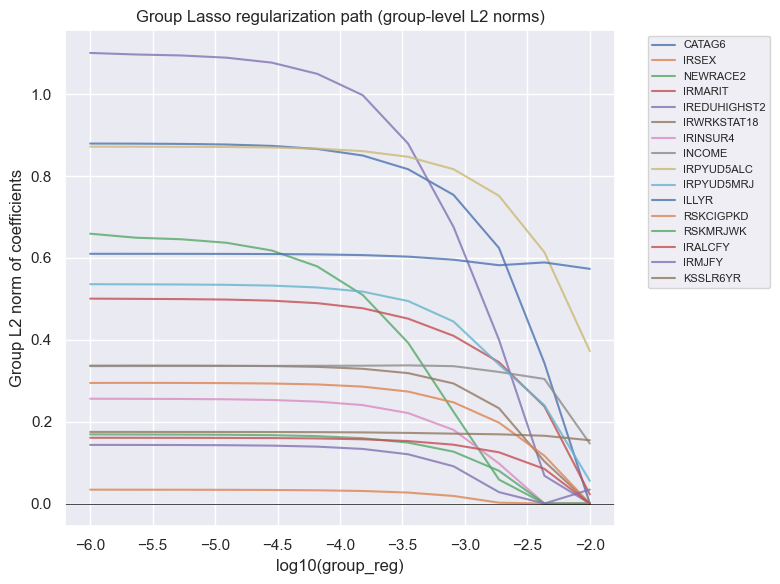

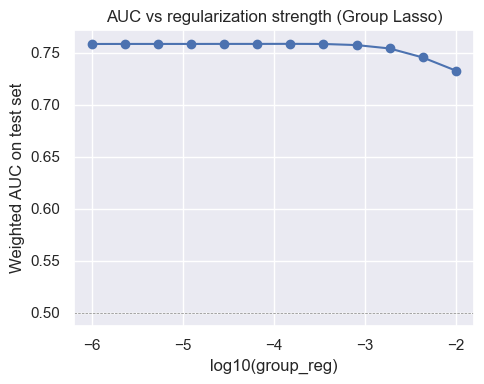

In [4]:
# ---------------------------------------------------------------------
# 1. Setup: target, weights, feature lists
# ---------------------------------------------------------------------
target = "SUTRTPY"
weight = "ANALWT2_C"

# Numeric (continuous count/score) features
numeric_cols = ["IRALCFY", "IRMJFY", "KSSLR6YR"]

# Treat coded fields as categorical (one-hot)
categorical_cols = [
    "CATAG6", "IRSEX", "NEWRACE2",
    "IRMARIT", "IREDUHIGHST2", "IRWRKSTAT18",
    "IRINSUR4", "INCOME",
    "IRPYUD5ALC", "IRPYUD5MRJ", "ILLYR",
    "RSKCIGPKD", "RSKMRJWK"
]

# ---------------------------------------------------------------------
# 2. Data subset + normalized weights
# ---------------------------------------------------------------------
# Assumes df already loaded and outdir defined elsewhere
work = df.loc[df[target].notna() & df[weight].notna()].copy()
work["w_norm"] = work[weight] / work[weight].mean()

X = work[categorical_cols + numeric_cols]
y = work[target].astype(int).to_numpy().ravel()
w = work["w_norm"].astype(float).to_numpy().ravel()

# Train / test split (NO resampling here)
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w,
    test_size=0.25,
    random_state=123,
    stratify=y
)

print("Class balance (train before resampling):", np.unique(y_train, return_counts=True))

# ---------------------------------------------------------------------
# 3. Oversample ONLY the training set (handle imbalance)
# ---------------------------------------------------------------------
ros = RandomOverSampler(random_state=123)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

print("Class balance (train AFTER resampling):", np.unique(y_train_res, return_counts=True))

# ---------------------------------------------------------------------
# 4. Preprocessor: impute + encode categoricals, impute + scale numerics
#    IMPORTANT: drop=None so group indices match encoded columns.
# ---------------------------------------------------------------------
pre = ColumnTransformer(
    transformers=[
        (
            "cat",
            Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("ohe", OneHotEncoder(
                    handle_unknown="ignore",
                    sparse_output=True,
                    drop=None          # no reference dropping for group lasso
                ))
            ]),
            categorical_cols
        ),
        (
            "num",
            Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler(with_mean=False))
            ]),
            numeric_cols
        ),
    ],
    remainder="drop",
    sparse_threshold=1.0
)

# Fit preprocessor on *resampled* training data
pre_gl = pre
pre_gl.fit(X_train_res)

# Transform training (resampled) and test (original)
X_train_gl = pre_gl.transform(X_train_res)
X_test_gl  = pre_gl.transform(X_test)

# Convert to dense numpy arrays for Group Lasso
if hasattr(X_train_gl, "toarray"):
    X_train_gl = X_train_gl.toarray()
if hasattr(X_test_gl, "toarray"):
    X_test_gl = X_test_gl.toarray()

print("X_train_gl shape:", X_train_gl.shape)

# ---------------------------------------------------------------------
# 5. Build groups vector for Group Lasso
#    - all dummies of a categorical var share one group id
#    - each numeric var is its own group
# ---------------------------------------------------------------------
# Categorical groups
ohe_gl = pre_gl.named_transformers_["cat"].named_steps["ohe"]
groups_cat = extract_ohe_groups(ohe_gl).astype(int)      # (n_cat_dummies,)
n_cat_groups = int(groups_cat.max()) + 1

# Numeric groups (one group per numeric feature)
n_num_features = len(numeric_cols)
groups_num = np.arange(n_num_features, dtype=int) + n_cat_groups

# Full groups vector (cat columns first, then numeric)
groups = np.concatenate([groups_cat, groups_num])

# Sanity check
assert X_train_gl.shape[1] == len(groups), (
    f"Group vector length {len(groups)} != n_features {X_train_gl.shape[1]}"
)

print("n_features:", X_train_gl.shape[1], " | n_groups:", groups.max() + 1)

# Feature names for later
cat_names = list(ohe_gl.get_feature_names_out(categorical_cols))
feature_names = cat_names + numeric_cols

# ---------------------------------------------------------------------
# 6. Small grid search over group_reg on the resampled training data
# ---------------------------------------------------------------------
group_reg_grid = [1e-5, 2.5e-5, 5e-5, 1e-4, 2.5e-4]
best_auc = -np.inf
best_model = None
best_group_reg = None

for gr in group_reg_grid:
    gl = LogisticGroupLasso(
        groups=groups,
        group_reg=gr,
        l1_reg=0.0,                    # only group penalty
        n_iter=3000,
        tol=1e-4,
        scale_reg="group_size",
        subsampling_scheme=None,
        fit_intercept=True,
        random_state=123,
        supress_warning=True
    )

    # Fit on *resampled* training data
    gl.fit(X_train_gl, y_train_res)

    # Evaluate on original test set with survey weights
    y_prob = gl.predict_proba(X_test_gl)[:, 1]
    y_hat = (y_prob >= 0.5).astype(int)

    auc = roc_auc_score(y_test, y_prob, sample_weight=w_test)
    acc = accuracy_score(y_test, y_hat, sample_weight=w_test)

    # count non-zero coefficients
    coef_mat = gl.coef_
    if coef_mat.ndim == 2 and coef_mat.shape[1] == 2:
        coef_vec_tmp = coef_mat[:, 1] - coef_mat[:, 0]
    else:
        coef_vec_tmp = coef_mat.ravel()
    nnz = int((np.abs(coef_vec_tmp) > 1e-6).sum())

    print(f"group_reg={gr:0.6f} | AUC={auc:0.3f} | Acc={acc:0.3f} | nnz={nnz}")

    if auc > best_auc:
        best_auc = auc
        best_model = gl
        best_group_reg = gr

print(f"\n[Group Lasso] Best group_reg={best_group_reg} with AUC={best_auc:.3f}")

gl = best_model  # use best model going forward

# ---------------------------------------------------------------------
# 7. Final evaluation (for the chosen group_reg)
# ---------------------------------------------------------------------
y_prob_gl = gl.predict_proba(X_test_gl)[:, 1]
y_hat_gl = (y_prob_gl >= 0.5).astype(int)

auc_gl = roc_auc_score(y_test, y_prob_gl, sample_weight=w_test)
acc_gl = accuracy_score(y_test, y_hat_gl, sample_weight=w_test)

print(f"[Group Lasso final] AUC (weighted): {auc_gl:.3f}")
print(f"[Group Lasso final] Accuracy (weighted, thr=0.5): {acc_gl:.3f}")

# ---------------------------------------------------------------------
# 8. Per-feature coefficients
# ---------------------------------------------------------------------
coef_mat = gl.coef_  # shape (n_features, n_classes) for logistic
if coef_mat.ndim == 2 and coef_mat.shape[1] == 2:
    coef_vec = coef_mat[:, 1] - coef_mat[:, 0]
else:
    coef_vec = coef_mat.ravel()

coef_df_gl = pd.DataFrame({
    "feature": feature_names,
    "coef": coef_vec
})
coef_df_gl["abs_coef"] = coef_df_gl["coef"].abs()
coef_df_gl = coef_df_gl.loc[coef_df_gl["abs_coef"] > 1e-6].copy()
coef_df_gl.sort_values("abs_coef", ascending=False, inplace=True)

print("\nTop 10 non-zero coefficients (dummy-level):")
print(coef_df_gl.head(10))

# ---------------------------------------------------------------------
# 9. Group-level (variable-level) importance
# ---------------------------------------------------------------------
# Build per-feature DataFrame with group ids
feat_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coef_vec,
    "group": groups
})
feat_df["abs_coef"] = feat_df["coef"].abs()

# Map group -> original variable name
group_to_var = {}

# Categorical part
ohe_feature_names = np.array(cat_names)
for j, feat_name in enumerate(ohe_feature_names):
    g = int(groups_cat[j])
    orig_var = feat_name.split("_")[0]
    group_to_var[g] = orig_var

# Numeric part
for i, num_var in enumerate(numeric_cols):
    g = n_cat_groups + i
    group_to_var[g] = num_var

feat_df["var_name"] = feat_df["group"].map(group_to_var)

# Group-level stats
grp_stats = (
    feat_df
    .groupby(["group", "var_name"], as_index=False)
    .agg(
        l2_norm=("coef", lambda x: float(np.linalg.norm(x, ord=2))),
        max_abs=("abs_coef", "max"),
        nnz=("abs_coef", lambda x: int((x > 1e-6).sum()))
    )
)

grp_stats.sort_values("l2_norm", ascending=False, inplace=True)

print("\nTop variables by GROUP (L2 norm of coefficients):")
print(grp_stats.head(20))

# ---------------------------------------------------------------------
# 10. Save metrics, coefficients, and group summary to disk
# ---------------------------------------------------------------------
out_subdir = os.path.join(outdir, "SUTRTPY", "group_lasso_output")
os.makedirs(out_subdir, exist_ok=True)

metrics_path = os.path.join(out_subdir, f"group_lasso_{target}_metrics.json")
with open(metrics_path, "w") as f:
    json.dump(
        {
            "best_group_reg": float(best_group_reg),
            "AUC_weighted": float(auc_gl),
            "Accuracy_weighted_thr0.5": float(acc_gl)
        },
        f,
        indent=2
    )

coef_path = os.path.join(out_subdir, f"group_lasso_{target}_coefficients.csv")
coef_df_gl[["feature", "coef"]].to_csv(coef_path, index=False)

group_summary_path = os.path.join(
    out_subdir, f"group_lasso_{target}_group_summary.csv"
)
grp_stats.to_csv(group_summary_path, index=False)

print(f"Saved Group Lasso metrics to: {metrics_path}")
print(f"Saved Group Lasso coefficients to: {coef_path}")
print(f"Saved Group-level summary to: {group_summary_path}")


# 1. Build robust mapping: group id -> parent variable name
#    We just look at each feature name and its group id.
group_to_var = {}
for j, fname in enumerate(feature_names):
    g = int(groups[j])
    base = fname.split("_")[0]  # e.g., "CATAG6_3.0" -> "CATAG6"
    # If multiple features share the same group, they all map to the same var
    if g not in group_to_var:
        group_to_var[g] = base

# 2. Define a grid of group_reg values for the path
group_reg_path = np.logspace(-6, -2, 12)  # e.g. 1e-6 to 1e-2
coef_list = []
auc_list = []

for gr in group_reg_path:
    gl_tmp = LogisticGroupLasso(
        groups=groups,
        group_reg=gr,
        l1_reg=0.0,
        n_iter=3000,
        tol=1e-4,
        scale_reg="group_size",
        subsampling_scheme=None,
        fit_intercept=True,
        random_state=123,
        supress_warning=True
    )

    gl_tmp.fit(X_train_gl, y_train_res)

    # store coefficients
    coef_mat = gl_tmp.coef_
    if coef_mat.ndim == 2 and coef_mat.shape[1] == 2:
        coef_vec = coef_mat[:, 1] - coef_mat[:, 0]
    else:
        coef_vec = coef_mat.ravel()
    coef_list.append(coef_vec)

    # OPTIONAL: AUC on original test set with survey weights
    y_prob_tmp = gl_tmp.predict_proba(X_test_gl)[:, 1]
    auc_tmp = roc_auc_score(y_test, y_prob_tmp, sample_weight=w_test)
    auc_list.append(auc_tmp)

coef_array = np.vstack(coef_list)  # shape = (n_lambdas, n_features)

# 3. Compute group-level L2 norms along the path
unique_groups = np.unique(groups)
group_norms = {}

for g in unique_groups:
    idx = (groups == g)
    norms_g = np.linalg.norm(coef_array[:, idx], axis=1)
    group_norms[g] = norms_g

# 4. Plot group-level trace: L2(group) vs log10(group_reg)
plt.figure(figsize=(8, 6))

for g in unique_groups:
    var_name = group_to_var.get(int(g), f"group_{g}")
    plt.plot(
        np.log10(group_reg_path),
        group_norms[g],
        label=var_name,
        alpha=0.8
    )

plt.xlabel("log10(group_reg)")
plt.ylabel("Group L2 norm of coefficients")
plt.title("Group Lasso regularization path (group-level L2 norms)")
plt.axhline(0, color="black", linewidth=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()

# 5. OPTIONAL: AUC vs log10(lambda) plot
plt.figure(figsize=(5, 4))
plt.plot(np.log10(group_reg_path), auc_list, marker="o")
plt.xlabel("log10(group_reg)")
plt.ylabel("Weighted AUC on test set")
plt.title("AUC vs regularization strength (Group Lasso)")
plt.axhline(0.5, color="gray", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


Class balance (train before resampling): (array([0, 1]), array([40378,  2150]))
Class balance (train AFTER resampling): (array([0, 1]), array([40378, 40378]))
X_train_gl shape: (80756, 57)
n_features: 57  | n_groups: 16
group_reg=0.000001 | AUC=0.758 | Acc=0.765 | nnz=57
group_reg=0.000002 | AUC=0.758 | Acc=0.765 | nnz=57
group_reg=0.000005 | AUC=0.758 | Acc=0.765 | nnz=57
group_reg=0.000012 | AUC=0.758 | Acc=0.765 | nnz=57
group_reg=0.000028 | AUC=0.759 | Acc=0.765 | nnz=57
group_reg=0.000066 | AUC=0.759 | Acc=0.765 | nnz=57
group_reg=0.000152 | AUC=0.759 | Acc=0.766 | nnz=57
group_reg=0.000351 | AUC=0.758 | Acc=0.766 | nnz=57
group_reg=0.000811 | AUC=0.757 | Acc=0.767 | nnz=57
group_reg=0.001874 | AUC=0.754 | Acc=0.771 | nnz=57
group_reg=0.004329 | AUC=0.745 | Acc=0.773 | nnz=41
group_reg=0.010000 | AUC=0.733 | Acc=0.744 | nnz=16

[Group Lasso] Best group_reg=0.0001519911082952933 with AUC=0.759
[Group Lasso final] AUC (weighted): 0.759
[Group Lasso final] Accuracy (weighted, thr=0.5

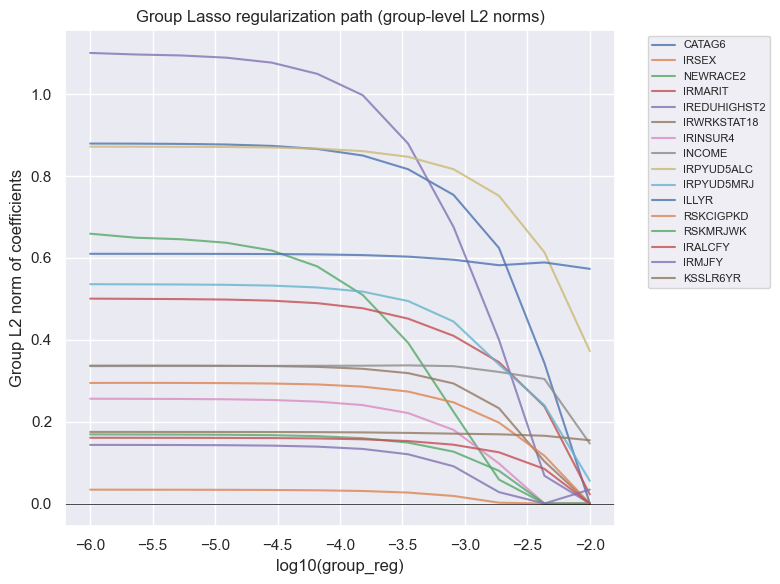

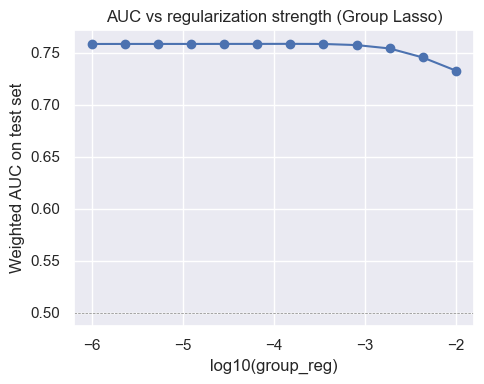

In [5]:
# ---------------------------------------------------------------------
# 1. Setup: target, weights, feature lists
# ---------------------------------------------------------------------
target = "SUTRTPY"
weight = "ANALWT2_C"

# Numeric (continuous count/score) features
numeric_cols = ["IRALCFY", "IRMJFY", "KSSLR6YR"]

# Treat coded fields as categorical (one-hot)
categorical_cols = [
    "CATAG6", "IRSEX", "NEWRACE2",
    "IRMARIT", "IREDUHIGHST2", "IRWRKSTAT18",
    "IRINSUR4", "INCOME",
    "IRPYUD5ALC", "IRPYUD5MRJ", "ILLYR",
    "RSKCIGPKD", "RSKMRJWK"
]

# ---------------------------------------------------------------------
# 2. Data subset + normalized weights
# ---------------------------------------------------------------------
# Assumes df already loaded and outdir defined elsewhere
work = df.loc[df[target].notna() & df[weight].notna()].copy()
work["w_norm"] = work[weight] / work[weight].mean()

X = work[categorical_cols + numeric_cols]
y = work[target].astype(int).to_numpy().ravel()
w = work["w_norm"].astype(float).to_numpy().ravel()

# Train / test split (NO resampling here)
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w,
    test_size=0.25,
    random_state=123,
    stratify=y
)

print("Class balance (train before resampling):", np.unique(y_train, return_counts=True))

# ---------------------------------------------------------------------
# 3. Oversample ONLY the training set (handle imbalance)
# ---------------------------------------------------------------------
ros = RandomOverSampler(random_state=123)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

print("Class balance (train AFTER resampling):", np.unique(y_train_res, return_counts=True))

# ---------------------------------------------------------------------
# 4. Preprocessor: impute + encode categoricals, impute + scale numerics
#    IMPORTANT: drop=None so group indices match encoded columns.
# ---------------------------------------------------------------------
pre = ColumnTransformer(
    transformers=[
        (
            "cat",
            Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("ohe", OneHotEncoder(
                    handle_unknown="ignore",
                    sparse_output=True,
                    drop=None          # no reference dropping for group lasso
                ))
            ]),
            categorical_cols
        ),
        (
            "num",
            Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler(with_mean=False))
            ]),
            numeric_cols
        ),
    ],
    remainder="drop",
    sparse_threshold=1.0
)

# Fit preprocessor on *resampled* training data
pre_gl = pre
pre_gl.fit(X_train_res)

# Transform training (resampled) and test (original)
X_train_gl = pre_gl.transform(X_train_res)
X_test_gl  = pre_gl.transform(X_test)

# Convert to dense numpy arrays for Group Lasso
if hasattr(X_train_gl, "toarray"):
    X_train_gl = X_train_gl.toarray()
if hasattr(X_test_gl, "toarray"):
    X_test_gl = X_test_gl.toarray()

print("X_train_gl shape:", X_train_gl.shape)

# ---------------------------------------------------------------------
# 5. Build groups vector for Group Lasso
#    - all dummies of a categorical var share one group id
#    - each numeric var is its own group
# ---------------------------------------------------------------------
# Categorical groups
ohe_gl = pre_gl.named_transformers_["cat"].named_steps["ohe"]
groups_cat = extract_ohe_groups(ohe_gl).astype(int)      # (n_cat_dummies,)
n_cat_groups = int(groups_cat.max()) + 1

# Numeric groups (one group per numeric feature)
n_num_features = len(numeric_cols)
groups_num = np.arange(n_num_features, dtype=int) + n_cat_groups

# Full groups vector (cat columns first, then numeric)
groups = np.concatenate([groups_cat, groups_num])

# Sanity check
assert X_train_gl.shape[1] == len(groups), (
    f"Group vector length {len(groups)} != n_features {X_train_gl.shape[1]}"
)

print("n_features:", X_train_gl.shape[1], " | n_groups:", groups.max() + 1)

# Feature names for later
cat_names = list(ohe_gl.get_feature_names_out(categorical_cols))
feature_names = cat_names + numeric_cols

# ---------------------------------------------------------------------
# 6. Grid over group_reg: tune, store path, and pick best in ONE loop
# ---------------------------------------------------------------------
# Use a single grid both for tuning and trace plot
group_reg_path = np.logspace(-6, -2, 12)  # or your [1e-5, 2.5e-5, ...] grid

best_auc = -np.inf
best_model = None
best_index = None

coef_list = []   # for trace plot: coef for each lambda
auc_list = []    # AUC for each lambda
acc_list = []    # Accuracy for each lambda
nnz_list = []    # number of non-zero coefficients

for i, gr in enumerate(group_reg_path):
    gl_tmp = LogisticGroupLasso(
        groups=groups,
        group_reg=gr,
        l1_reg=0.0,                    # only group penalty
        n_iter=3000,
        tol=1e-4,
        scale_reg="group_size",
        subsampling_scheme=None,
        fit_intercept=True,
        random_state=123,
        supress_warning=True
    )

    # Fit on *resampled* training data
    gl_tmp.fit(X_train_gl, y_train_res)

    # Coefficients for this lambda
    coef_mat = gl_tmp.coef_
    if coef_mat.ndim == 2 and coef_mat.shape[1] == 2:
        coef_vec = coef_mat[:, 1] - coef_mat[:, 0]
    else:
        coef_vec = coef_mat.ravel()
    coef_list.append(coef_vec)

    # Evaluate on original test set with survey weights
    y_prob = gl_tmp.predict_proba(X_test_gl)[:, 1]
    y_hat = (y_prob >= 0.5).astype(int)

    auc = roc_auc_score(y_test, y_prob, sample_weight=w_test)
    acc = accuracy_score(y_test, y_hat, sample_weight=w_test)
    nnz = int((np.abs(coef_vec) > 1e-6).sum())

    auc_list.append(auc)
    acc_list.append(acc)
    nnz_list.append(nnz)

    print(f"group_reg={gr:0.6f} | AUC={auc:0.3f} | Acc={acc:0.3f} | nnz={nnz}")

    # Track best model
    if auc > best_auc:
        best_auc = auc
        best_model = gl_tmp
        best_index = i

best_group_reg = float(group_reg_path[best_index])
gl = best_model  # final model

print(f"\n[Group Lasso] Best group_reg={best_group_reg} with AUC={best_auc:.3f}")

# Stack coefficients into array for trace plot
coef_array = np.vstack(coef_list)  # shape: (n_lambdas, n_features)

# ---------------------------------------------------------------------
# 7. Final evaluation for chosen group_reg (optional re-compute)
# ---------------------------------------------------------------------
y_prob_gl = gl.predict_proba(X_test_gl)[:, 1]
y_hat_gl = (y_prob_gl >= 0.5).astype(int)

auc_gl = roc_auc_score(y_test, y_prob_gl, sample_weight=w_test)
acc_gl = accuracy_score(y_test, y_hat_gl, sample_weight=w_test)

print(f"[Group Lasso final] AUC (weighted): {auc_gl:.3f}")
print(f"[Group Lasso final] Accuracy (weighted, thr=0.5): {acc_gl:.3f}")

# ---------------------------------------------------------------------
# 8. Per-feature coefficients (for best lambda only)
# ---------------------------------------------------------------------
coef_vec_best = coef_array[best_index, :]

coef_df_gl = pd.DataFrame({
    "feature": feature_names,
    "coef": coef_vec_best
})
coef_df_gl["abs_coef"] = coef_df_gl["coef"].abs()
coef_df_gl = coef_df_gl.loc[coef_df_gl["abs_coef"] > 1e-6].copy()
coef_df_gl.sort_values("abs_coef", ascending=False, inplace=True)

print("\nTop 10 non-zero coefficients (dummy-level):")
print(coef_df_gl.head(10))

# ---------------------------------------------------------------------
# 9. Group-level importance for BEST lambda
# ---------------------------------------------------------------------
feat_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coef_vec_best,
    "group": groups
})
feat_df["abs_coef"] = feat_df["coef"].abs()

# Map group -> original variable name directly from feature names
group_to_var = {}
for j, fname in enumerate(feature_names):
    g = int(groups[j])
    base = fname.split("_")[0]
    if g not in group_to_var:
        group_to_var[g] = base

feat_df["var_name"] = feat_df["group"].map(group_to_var)

grp_stats = (
    feat_df
    .groupby(["group", "var_name"], as_index=False)
    .agg(
        l2_norm=("coef", lambda x: float(np.linalg.norm(x, ord=2))),
        max_abs=("abs_coef", "max"),
        nnz=("abs_coef", lambda x: int((x > 1e-6).sum()))
    )
)
grp_stats.sort_values("l2_norm", ascending=False, inplace=True)

print("\nTop variables by GROUP (L2 norm of coefficients):")
print(grp_stats.head(20))

# ---------------------------------------------------------------------
# 10. Build trace data (group-level L2 norms across lambdas) and SAVE
# ---------------------------------------------------------------------
unique_groups = np.unique(groups)
group_norms = {}

for g in unique_groups:
    idx = (groups == g)
    norms_g = np.linalg.norm(coef_array[:, idx], axis=1)
    group_norms[g] = norms_g

# Long-form DataFrame: one row per (lambda, group)
trace_rows = []
for li, gr in enumerate(group_reg_path):
    for g in unique_groups:
        trace_rows.append({
            "group_reg": float(gr),
            "log10_group_reg": float(np.log10(gr)),
            "group": int(g),
            "var_name": group_to_var[int(g)],
            "l2_norm": float(group_norms[g][li]),
            "auc": float(auc_list[li]),
            "acc": float(acc_list[li]),
            "nnz": int(nnz_list[li]),
        })

trace_df = pd.DataFrame(trace_rows)

# ---------------------------------------------------------------------
# 11. Save everything to disk
# ---------------------------------------------------------------------
out_subdir = os.path.join(outdir, "SUTRTPY", "group_lasso_output")
os.makedirs(out_subdir, exist_ok=True)

metrics_path = os.path.join(out_subdir, f"group_lasso_{target}_metrics.json")
with open(metrics_path, "w") as f:
    json.dump(
        {
            "best_group_reg": best_group_reg,
            "AUC_weighted": float(auc_gl),
            "Accuracy_weighted_thr0.5": float(acc_gl)
        },
        f,
        indent=2
    )

coef_path = os.path.join(out_subdir, f"group_lasso_{target}_coefficients.csv")
coef_df_gl[["feature", "coef"]].to_csv(coef_path, index=False)

group_summary_path = os.path.join(
    out_subdir, f"group_lasso_{target}_group_summary.csv"
)
grp_stats.to_csv(group_summary_path, index=False)

trace_path = os.path.join(
    out_subdir, f"group_lasso_{target}_trace_data.csv"
)
trace_df.to_csv(trace_path, index=False)

print(f"Saved Group Lasso metrics to: {metrics_path}")
print(f"Saved Group Lasso coefficients to: {coef_path}")
print(f"Saved Group-level summary to: {group_summary_path}")
print(f"Saved trace data to: {trace_path}")

# ---------------------------------------------------------------------
# 12. Plot trace and AUC using the saved arrays (no extra fitting)
# ---------------------------------------------------------------------
plt.figure(figsize=(8, 6))
for g in unique_groups:
    var_name = group_to_var.get(int(g), f"group_{g}")
    plt.plot(
        np.log10(group_reg_path),
        group_norms[g],
        label=var_name,
        alpha=0.8
    )

plt.xlabel("log10(group_reg)")
plt.ylabel("Group L2 norm of coefficients")
plt.title("Group Lasso regularization path (group-level L2 norms)")
plt.axhline(0, color="black", linewidth=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 4))
plt.plot(np.log10(group_reg_path), auc_list, marker="o")
plt.xlabel("log10(group_reg)")
plt.ylabel("Weighted AUC on test set")
plt.title("AUC vs regularization strength (Group Lasso)")
plt.axhline(0.5, color="gray", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

#### 4.2. Logistic Regression Model for SUTRTPY using variables captured by Group LASSO

In [16]:
target = "SUTRTPY"
weight = "ANALWT2_C"

# Top 10 LASSO predictors by absolute coefficient
top_lasso_features = [
    "IREDUHIGHST2",
    "CATAG6",
    "IRPYUD5ALC",
    "ILLYR",
    "NEWRACE2",
    "IRPYUD5MRJ",
    "IRMARIT",
    "INCOME",
    "IRWRKSTAT18",
    "RSKCIGPKD"
]

selected_features = list(dict.fromkeys(top_lasso_features))  # ensure uniqueness

print("Variables included in final model:")
for v in selected_features:
    print("-", v)

# Prepare data
cols_for_model = [target, weight] + selected_features
work = df.loc[df[target].notna() & df[weight].notna(), cols_for_model].copy()
work[target] = pd.to_numeric(work[target], errors="coerce")
work[weight] = pd.to_numeric(work[weight], errors="coerce")
work = work.dropna(subset=selected_features)
# Identify numeric predictors (continuous)
numeric_cols = ["KSSLR6YR"]
categorical_cols = [c for c in selected_features if c not in numeric_cols]

# Median impute numeric
#for c in numeric_cols:
#    med = pd.to_numeric(work[c], errors="coerce").median()
#    work[c] = pd.to_numeric(work[c], errors="coerce").fillna(med)

# Dummy encoding and cleanup
X_parts = []
for c in categorical_cols:
    # replace NaN with a literal "Missing" category
    work[c] = work[c].astype("category")
    dummies = pd.get_dummies(work[c], prefix=c, drop_first=True)
    X_parts.append(dummies)

X_cat = pd.concat(X_parts, axis=1)
#X_num = work[numeric_cols]
X = pd.concat([X_cat], axis=1)

# Coerce to numeric and clean
X = X.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
y = pd.to_numeric(work[target], errors="coerce")
w = pd.to_numeric(work[weight], errors="coerce")

keep = X.notna().all(axis=1) & y.notna() & w.notna()
X = X.loc[keep]
y = y.loc[keep]
w = w.loc[keep]

# Drop constant or duplicate columns
X = X.loc[:, X.nunique(dropna=False) > 1]
X = X.loc[:, ~X.T.duplicated()]

# Add intercept
X = sm.add_constant(X).astype(float)
y = y.astype(float)
w = w.astype(float)

print(f"\nModel fitting on {len(X):,} observations, {X.shape[1]} predictors.")

# weighted logistic regression (robust SEs)
N = len(w)
w_freq = w * (N / w.sum())   # scale such that sum(w_freq) == N

print("sum(freq_weights) =", w_freq.sum())  # sanity: should equal N
print("rank(X) vs cols:", np.linalg.matrix_rank(X.values), X.shape[1])

model = sm.GLM(y, X, family=sm.families.Binomial(), freq_weights=w_freq).fit(cov_type="HC1")
print(model.summary())

# Compute Odds Ratios with 95% CI
ci = model.conf_int()
ci.columns = ["2.5%", "97.5%"]
or_table = pd.DataFrame({
    "OR": np.exp(model.params),
    "2.5%": np.exp(ci["2.5%"]),
    "97.5%": np.exp(ci["97.5%"]),
    "p-value": model.pvalues
}).sort_values("OR", ascending=False)

print("\nTop predictors by OR:")
print(or_table.head(15))

print("\nLowest predictors by OR:")
print(or_table.tail(15))

# Save text summary
with open(os.path.join(outdir + "/SUTRTPY/glm_output/", f"glm_{target}_summary.txt"), "w") as f:
    f.write(model.summary().as_text())

# Save full OR table
or_table.to_csv(os.path.join(outdir + "/SUTRTPY/glm_output/", f"glm_{target}_or_table.csv"))

# Save compact (manuscript-ready) table
nice = or_table.copy()
nice["OR (95% CI)"] = nice.apply(lambda r: f'{r["OR"]:.2f} ({r["2.5%"]:.2f}, {r["97.5%"]:.2f})', axis=1)
nice = nice[["OR (95% CI)", "p-value"]]
nice.to_csv(os.path.join(outdir + "/SUTRTPY/glm_output/", f"glm_{target}_or_table_compact.csv"))

Variables included in final model:
- IREDUHIGHST2
- CATAG6
- IRPYUD5ALC
- ILLYR
- NEWRACE2
- IRPYUD5MRJ
- IRMARIT
- INCOME
- IRWRKSTAT18
- RSKCIGPKD

Model fitting on 44,596 observations, 36 predictors.
sum(freq_weights) = 44596.00000000001
rank(X) vs cols: 36 36
                 Generalized Linear Model Regression Results                  
Dep. Variable:                SUTRTPY   No. Observations:                44596
Model:                            GLM   Df Residuals:                 44560.00
Model Family:                Binomial   Df Model:                           35
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7027.8
Date:                Fri, 05 Dec 2025   Deviance:                       14056.
Time:                        00:35:10   Pearson chi2:                 4.45e+04
No. Iterations:                     7   Pseudo R-squ. (CS):            0.04793
Covariance Type:         

#### 4.3. Random Forest Model for SUTRTPY

In [19]:
target = "SUTRTPY"   
weight = "ANALWT2_C"

numeric_cols = ["IRALCFY", "IRMJFY", "KSSLR6YR"]

categorical_cols = [
    "CATAG6","IRSEX","NEWRACE2",
    "IRMARIT","IREDUHIGHST2","IRWRKSTAT18",
    "IRINSUR4","INCOME",
    "IRPYUD5ALC","IRPYUD5MRJ","ILLYR",
    "RSKCIGPKD","RSKMRJWK"
]

work = df.loc[df[target].notna() & df[weight].notna()].copy()
work["w_norm"] = work[weight] / work[weight].mean()

X = work[categorical_cols + numeric_cols]
y = work[target].astype(int).to_numpy().ravel()
w = work["w_norm"].astype(float).to_numpy().ravel()

# Train-test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, test_size=0.25, random_state=123, stratify=y
)

# Preprocessing
pre = ColumnTransformer(
    transformers=[
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first"))
        ]), categorical_cols),
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_cols),
    ],
    remainder="drop"
)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=123,
    n_jobs=-1,
    class_weight=None  
)

pipe_rf = Pipeline([
    ("pre", pre),
    ("clf", rf)
])

pipe_rf.fit(X_train, y_train, clf__sample_weight=w_train)

# Evaluate
y_prob = pipe_rf.predict_proba(X_test)[:, 1]
y_hat  = (y_prob >= 0.5).astype(int)

auc = roc_auc_score(y_test, y_prob, sample_weight=w_test)
acc = accuracy_score(y_test, y_hat, sample_weight=w_test)

print(f"\nRandom Forest results for {target}:")
print(f"AUC (weighted): {auc:.3f}")
print(f"Accuracy (weighted, thr=0.5): {acc:.3f}")

metrics = {
    "target": target,
    "AUC_weighted": float(auc),
    "Accuracy_weighted_thr0.5": float(acc),
    "N_train": len(y_train),
    "N_test": len(y_test)
}

# Save metrics JSON
with open(os.path.join(outdir + "/SUTRTPY/rf_output/", f"rf_{target}_metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

# Feature Importance
# Get feature names after preprocessing
cat_names = pipe_rf.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"].get_feature_names_out(categorical_cols)
feature_names = list(cat_names) + numeric_cols

importances = pipe_rf.named_steps["clf"].feature_importances_
imp_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
imp_df = imp_df.sort_values("Importance", ascending=False)

imp_df.to_csv(os.path.join(outdir + "/SUTRTPY/rf_output/", f"rf_{target}_feature_importance.csv"), index=False)


Random Forest results for SUTRTPY:
AUC (weighted): 0.782
Accuracy (weighted, thr=0.5): 0.957


#### 4.4. LASSO Logistic Regression Model for MHTRTPY

Class balance (train before resampling): (array([0, 1]), array([30806, 11722]))
Class balance (train AFTER resampling): (array([0, 1]), array([30806, 30806]))
X_train_gl shape: (61612, 57)
n_features: 57  | n_groups: 16
group_reg=0.000001 | AUC=0.701 | Acc=0.684 | nnz=57
group_reg=0.000002 | AUC=0.701 | Acc=0.684 | nnz=57
group_reg=0.000005 | AUC=0.701 | Acc=0.684 | nnz=57
group_reg=0.000012 | AUC=0.701 | Acc=0.684 | nnz=57
group_reg=0.000028 | AUC=0.701 | Acc=0.684 | nnz=57
group_reg=0.000066 | AUC=0.701 | Acc=0.683 | nnz=57
group_reg=0.000152 | AUC=0.701 | Acc=0.683 | nnz=57
group_reg=0.000351 | AUC=0.699 | Acc=0.685 | nnz=57
group_reg=0.000811 | AUC=0.696 | Acc=0.682 | nnz=57
group_reg=0.001874 | AUC=0.688 | Acc=0.667 | nnz=48
group_reg=0.004329 | AUC=0.670 | Acc=0.633 | nnz=29
group_reg=0.010000 | AUC=0.632 | Acc=0.571 | nnz=13

[Group Lasso] Best group_reg=1e-06 with AUC=0.701
[Group Lasso final] AUC (weighted): 0.701
[Group Lasso final] Accuracy (weighted, thr=0.5): 0.684

Top 10

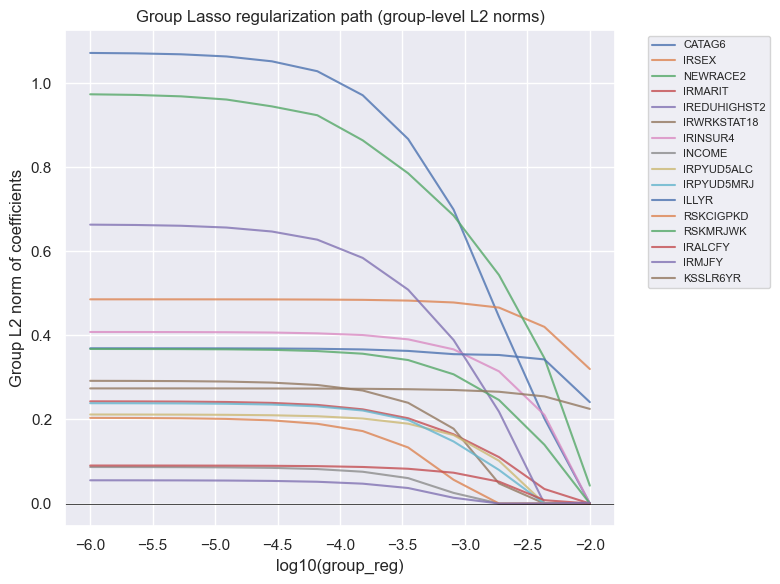

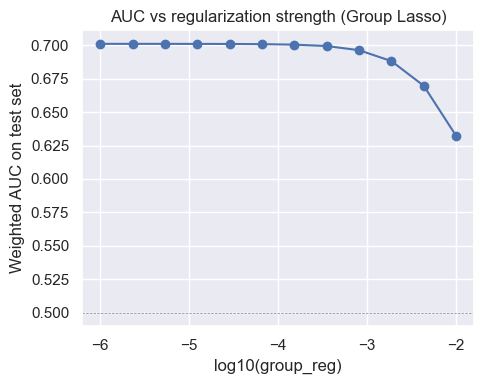

In [6]:
# ---------------------------------------------------------------------
# 1. Setup: target, weights, feature lists
# ---------------------------------------------------------------------
target = "MHTRTPY"
weight = "ANALWT2_C"

# Numeric (continuous count/score) features
numeric_cols = ["IRALCFY", "IRMJFY", "KSSLR6YR"]

# Treat coded fields as categorical (one-hot)
categorical_cols = [
    "CATAG6", "IRSEX", "NEWRACE2",
    "IRMARIT", "IREDUHIGHST2", "IRWRKSTAT18",
    "IRINSUR4", "INCOME",
    "IRPYUD5ALC", "IRPYUD5MRJ", "ILLYR",
    "RSKCIGPKD", "RSKMRJWK"
]

# ---------------------------------------------------------------------
# 2. Data subset + normalized weights
# ---------------------------------------------------------------------
# Assumes df already loaded and outdir defined elsewhere
work = df.loc[df[target].notna() & df[weight].notna()].copy()
work["w_norm"] = work[weight] / work[weight].mean()

X = work[categorical_cols + numeric_cols]
y = work[target].astype(int).to_numpy().ravel()
w = work["w_norm"].astype(float).to_numpy().ravel()

# Train / test split (NO resampling here)
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w,
    test_size=0.25,
    random_state=123,
    stratify=y
)

print("Class balance (train before resampling):", np.unique(y_train, return_counts=True))

# ---------------------------------------------------------------------
# 3. Oversample ONLY the training set (handle imbalance)
# ---------------------------------------------------------------------
ros = RandomOverSampler(random_state=123)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

print("Class balance (train AFTER resampling):", np.unique(y_train_res, return_counts=True))

# ---------------------------------------------------------------------
# 4. Preprocessor: impute + encode categoricals, impute + scale numerics
#    IMPORTANT: drop=None so group indices match encoded columns.
# ---------------------------------------------------------------------
pre = ColumnTransformer(
    transformers=[
        (
            "cat",
            Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("ohe", OneHotEncoder(
                    handle_unknown="ignore",
                    sparse_output=True,
                    drop=None          # no reference dropping for group lasso
                ))
            ]),
            categorical_cols
        ),
        (
            "num",
            Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler(with_mean=False))
            ]),
            numeric_cols
        ),
    ],
    remainder="drop",
    sparse_threshold=1.0
)

# Fit preprocessor on *resampled* training data
pre_gl = pre
pre_gl.fit(X_train_res)

# Transform training (resampled) and test (original)
X_train_gl = pre_gl.transform(X_train_res)
X_test_gl  = pre_gl.transform(X_test)

# Convert to dense numpy arrays for Group Lasso
if hasattr(X_train_gl, "toarray"):
    X_train_gl = X_train_gl.toarray()
if hasattr(X_test_gl, "toarray"):
    X_test_gl = X_test_gl.toarray()

print("X_train_gl shape:", X_train_gl.shape)

# ---------------------------------------------------------------------
# 5. Build groups vector for Group Lasso
#    - all dummies of a categorical var share one group id
#    - each numeric var is its own group
# ---------------------------------------------------------------------
# Categorical groups
ohe_gl = pre_gl.named_transformers_["cat"].named_steps["ohe"]
groups_cat = extract_ohe_groups(ohe_gl).astype(int)      # (n_cat_dummies,)
n_cat_groups = int(groups_cat.max()) + 1

# Numeric groups (one group per numeric feature)
n_num_features = len(numeric_cols)
groups_num = np.arange(n_num_features, dtype=int) + n_cat_groups

# Full groups vector (cat columns first, then numeric)
groups = np.concatenate([groups_cat, groups_num])

# Sanity check
assert X_train_gl.shape[1] == len(groups), (
    f"Group vector length {len(groups)} != n_features {X_train_gl.shape[1]}"
)

print("n_features:", X_train_gl.shape[1], " | n_groups:", groups.max() + 1)

# Feature names for later
cat_names = list(ohe_gl.get_feature_names_out(categorical_cols))
feature_names = cat_names + numeric_cols

# ---------------------------------------------------------------------
# 6. Grid over group_reg: tune, store path, and pick best in ONE loop
# ---------------------------------------------------------------------
# Use a single grid both for tuning and trace plot
group_reg_path = np.logspace(-6, -2, 12)  # or your [1e-5, 2.5e-5, ...] grid

best_auc = -np.inf
best_model = None
best_index = None

coef_list = []   # for trace plot: coef for each lambda
auc_list = []    # AUC for each lambda
acc_list = []    # Accuracy for each lambda
nnz_list = []    # number of non-zero coefficients

for i, gr in enumerate(group_reg_path):
    gl_tmp = LogisticGroupLasso(
        groups=groups,
        group_reg=gr,
        l1_reg=0.0,                    # only group penalty
        n_iter=3000,
        tol=1e-4,
        scale_reg="group_size",
        subsampling_scheme=None,
        fit_intercept=True,
        random_state=123,
        supress_warning=True
    )

    # Fit on *resampled* training data
    gl_tmp.fit(X_train_gl, y_train_res)

    # Coefficients for this lambda
    coef_mat = gl_tmp.coef_
    if coef_mat.ndim == 2 and coef_mat.shape[1] == 2:
        coef_vec = coef_mat[:, 1] - coef_mat[:, 0]
    else:
        coef_vec = coef_mat.ravel()
    coef_list.append(coef_vec)

    # Evaluate on original test set with survey weights
    y_prob = gl_tmp.predict_proba(X_test_gl)[:, 1]
    y_hat = (y_prob >= 0.5).astype(int)

    auc = roc_auc_score(y_test, y_prob, sample_weight=w_test)
    acc = accuracy_score(y_test, y_hat, sample_weight=w_test)
    nnz = int((np.abs(coef_vec) > 1e-6).sum())

    auc_list.append(auc)
    acc_list.append(acc)
    nnz_list.append(nnz)

    print(f"group_reg={gr:0.6f} | AUC={auc:0.3f} | Acc={acc:0.3f} | nnz={nnz}")

    # Track best model
    if auc > best_auc:
        best_auc = auc
        best_model = gl_tmp
        best_index = i

best_group_reg = float(group_reg_path[best_index])
gl = best_model  # final model

print(f"\n[Group Lasso] Best group_reg={best_group_reg} with AUC={best_auc:.3f}")

# Stack coefficients into array for trace plot
coef_array = np.vstack(coef_list)  # shape: (n_lambdas, n_features)

# ---------------------------------------------------------------------
# 7. Final evaluation for chosen group_reg (optional re-compute)
# ---------------------------------------------------------------------
y_prob_gl = gl.predict_proba(X_test_gl)[:, 1]
y_hat_gl = (y_prob_gl >= 0.5).astype(int)

auc_gl = roc_auc_score(y_test, y_prob_gl, sample_weight=w_test)
acc_gl = accuracy_score(y_test, y_hat_gl, sample_weight=w_test)

print(f"[Group Lasso final] AUC (weighted): {auc_gl:.3f}")
print(f"[Group Lasso final] Accuracy (weighted, thr=0.5): {acc_gl:.3f}")

# ---------------------------------------------------------------------
# 8. Per-feature coefficients (for best lambda only)
# ---------------------------------------------------------------------
coef_vec_best = coef_array[best_index, :]

coef_df_gl = pd.DataFrame({
    "feature": feature_names,
    "coef": coef_vec_best
})
coef_df_gl["abs_coef"] = coef_df_gl["coef"].abs()
coef_df_gl = coef_df_gl.loc[coef_df_gl["abs_coef"] > 1e-6].copy()
coef_df_gl.sort_values("abs_coef", ascending=False, inplace=True)

print("\nTop 10 non-zero coefficients (dummy-level):")
print(coef_df_gl.head(10))

# ---------------------------------------------------------------------
# 9. Group-level importance for BEST lambda
# ---------------------------------------------------------------------
feat_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coef_vec_best,
    "group": groups
})
feat_df["abs_coef"] = feat_df["coef"].abs()

# Map group -> original variable name directly from feature names
group_to_var = {}
for j, fname in enumerate(feature_names):
    g = int(groups[j])
    base = fname.split("_")[0]
    if g not in group_to_var:
        group_to_var[g] = base

feat_df["var_name"] = feat_df["group"].map(group_to_var)

grp_stats = (
    feat_df
    .groupby(["group", "var_name"], as_index=False)
    .agg(
        l2_norm=("coef", lambda x: float(np.linalg.norm(x, ord=2))),
        max_abs=("abs_coef", "max"),
        nnz=("abs_coef", lambda x: int((x > 1e-6).sum()))
    )
)
grp_stats.sort_values("l2_norm", ascending=False, inplace=True)

print("\nTop variables by GROUP (L2 norm of coefficients):")
print(grp_stats.head(20))

# ---------------------------------------------------------------------
# 10. Build trace data (group-level L2 norms across lambdas) and SAVE
# ---------------------------------------------------------------------
unique_groups = np.unique(groups)
group_norms = {}

for g in unique_groups:
    idx = (groups == g)
    norms_g = np.linalg.norm(coef_array[:, idx], axis=1)
    group_norms[g] = norms_g

# Long-form DataFrame: one row per (lambda, group)
trace_rows = []
for li, gr in enumerate(group_reg_path):
    for g in unique_groups:
        trace_rows.append({
            "group_reg": float(gr),
            "log10_group_reg": float(np.log10(gr)),
            "group": int(g),
            "var_name": group_to_var[int(g)],
            "l2_norm": float(group_norms[g][li]),
            "auc": float(auc_list[li]),
            "acc": float(acc_list[li]),
            "nnz": int(nnz_list[li]),
        })

trace_df = pd.DataFrame(trace_rows)

# ---------------------------------------------------------------------
# 11. Save everything to disk
# ---------------------------------------------------------------------
out_subdir = os.path.join(outdir, "SUTRTPY", "group_lasso_output")
os.makedirs(out_subdir, exist_ok=True)

metrics_path = os.path.join(out_subdir, f"group_lasso_{target}_metrics.json")
with open(metrics_path, "w") as f:
    json.dump(
        {
            "best_group_reg": best_group_reg,
            "AUC_weighted": float(auc_gl),
            "Accuracy_weighted_thr0.5": float(acc_gl)
        },
        f,
        indent=2
    )

coef_path = os.path.join(out_subdir, f"group_lasso_{target}_coefficients.csv")
coef_df_gl[["feature", "coef"]].to_csv(coef_path, index=False)

group_summary_path = os.path.join(
    out_subdir, f"group_lasso_{target}_group_summary.csv"
)
grp_stats.to_csv(group_summary_path, index=False)

trace_path = os.path.join(
    out_subdir, f"group_lasso_{target}_trace_data.csv"
)
trace_df.to_csv(trace_path, index=False)

print(f"Saved Group Lasso metrics to: {metrics_path}")
print(f"Saved Group Lasso coefficients to: {coef_path}")
print(f"Saved Group-level summary to: {group_summary_path}")
print(f"Saved trace data to: {trace_path}")

# ---------------------------------------------------------------------
# 12. Plot trace and AUC using the saved arrays (no extra fitting)
# ---------------------------------------------------------------------
plt.figure(figsize=(8, 6))
for g in unique_groups:
    var_name = group_to_var.get(int(g), f"group_{g}")
    plt.plot(
        np.log10(group_reg_path),
        group_norms[g],
        label=var_name,
        alpha=0.8
    )

plt.xlabel("log10(group_reg)")
plt.ylabel("Group L2 norm of coefficients")
plt.title("Group Lasso regularization path (group-level L2 norms)")
plt.axhline(0, color="black", linewidth=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 4))
plt.plot(np.log10(group_reg_path), auc_list, marker="o")
plt.xlabel("log10(group_reg)")
plt.ylabel("Weighted AUC on test set")
plt.title("AUC vs regularization strength (Group Lasso)")
plt.axhline(0.5, color="gray", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

In [19]:
# 1. Build mapping: group id -> original variable name
group_to_var = {}

# Categorical part
ohe_feature_names = np.array(cat_names)
for j, feat_name in enumerate(ohe_feature_names):
    g = int(groups_cat[j])
    orig_var = feat_name.split("_")[0]
    group_to_var[g] = orig_var

# Numeric part
for i, num_var in enumerate(numeric_cols):
    g = n_cat_groups + i
    group_to_var[g] = num_var

# Full feature name list
feature_names = list(cat_names) + numeric_cols

# 2. Define a grid of group_reg values for the path
group_reg_path = np.logspace(-6, -2, 12)  # e.g. 1e-6 ... 1e-2
coef_list = []
auc_list = []

for gr in group_reg_path:
    gl_tmp = LogisticGroupLasso(
        groups=groups,
        group_reg=gr,
        l1_reg=0.0,
        n_iter=3000,
        tol=1e-4,
        scale_reg="group_size",
        subsampling_scheme=None,
        fit_intercept=True,
        random_state=123,
        supress_warning=True
    )

    gl_tmp.fit(X_train_gl, y_train_res)

    # store coefficients
    coef_mat = gl_tmp.coef_
    if coef_mat.ndim == 2 and coef_mat.shape[1] == 2:
        coef_vec = coef_mat[:, 1] - coef_mat[:, 0]
    else:
        coef_vec = coef_mat.ravel()
    coef_list.append(coef_vec)

    # OPTIONAL: store AUC for reference
    y_prob_tmp = gl_tmp.predict_proba(X_test_gl)[:, 1]
    auc_tmp = roc_auc_score(y_test, y_prob_tmp, sample_weight=w_test)
    auc_list.append(auc_tmp)

coef_array = np.vstack(coef_list)  # shape: (n_lambdas, n_features)

# 3. Compute group-level L2 norms along the path
unique_groups = np.unique(groups)
group_names = [group_to_var[g] for g in unique_groups]

group_norms = {}
for g in unique_groups:
    idx = (groups == g)
    # L2 norm of this group's coefficients at each lambda
    norms_g = np.linalg.norm(coef_array[:, idx], axis=1)
    group_norms[g] = norms_g

# 4. Plot group-level trace plots: L2(group) vs log10(group_reg)
plt.figure(figsize=(8, 6))

for g in unique_groups:
    var_name = group_to_var[g]
    plt.plot(
        np.log10(group_reg_path),
        group_norms[g],
        label=var_name,
        alpha=0.8
    )

plt.xlabel("log10(group_reg)")
plt.ylabel("Group L2 norm of coefficients")
plt.title("Group Lasso regularization path (group-level L2 norms)")
plt.axhline(0, color="black", linewidth=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()

# 5. OPTIONAL: AUC vs log10(lambda) plot
plt.figure(figsize=(5, 4))
plt.plot(np.log10(group_reg_path), auc_list, marker="o")
plt.xlabel("log10(group_reg)")
plt.ylabel("Weighted AUC on test set")
plt.title("AUC vs regularization strength (Group Lasso)")
plt.axhline(0.5, color="gray", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

KeyError: np.int64(14)

#### 4.5. Logistic Regression Model for MHTRTPY using variables captured by LASSO

In [18]:
target = "MHTRTPY"
weight = "ANALWT2_C"

# Top 10 LASSO predictors
top_lasso_features = [
    "CATAG6",
    "NEWRACE2",
    "IREDUHIGHST2",
    "IRSEX",
    "IRINSUR4",
    "ILLYR",
    "RSKMRJWK",
    "IRWRKSTAT18",
    "KSSLR6YR",
    "IRMARIT"
]

selected_features = list(dict.fromkeys(top_lasso_features))

print("Variables included in MHTRTPY model:")
for v in selected_features:
    print("-", v)

# Prepare data
cols_for_model = [target, weight] + selected_features
work = df.loc[df[target].notna() & df[weight].notna(), cols_for_model].copy()
work[target] = pd.to_numeric(work[target], errors="coerce")
work[weight] = pd.to_numeric(work[weight], errors="coerce")
work = work.dropna(subset=selected_features)

# Numeric vs categorical
numeric_cols = ["KSSLR6YR"]
categorical_cols = [c for c in selected_features if c not in numeric_cols]

# Median impute numeric
#for c in numeric_cols:
#    med = pd.to_numeric(work[c], errors="coerce").median()
#    work[c] = pd.to_numeric(work[c], errors="coerce").fillna(med)

# Dummy encoding (explicit Missing category)
X_parts = []
for c in categorical_cols:
    work[c] = work[c].astype("category")
    dummies = pd.get_dummies(work[c], prefix=c, drop_first=True)
    X_parts.append(dummies)

X_cat = pd.concat(X_parts, axis=1)
#X_num = work[numeric_cols]
X = pd.concat([X_cat], axis=1)

# Clean dtypes
X = X.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
y = pd.to_numeric(work[target], errors="coerce")
w = pd.to_numeric(work[weight], errors="coerce")

keep = X.notna().all(axis=1) & y.notna() & w.notna()
X = X.loc[keep]
y = y.loc[keep]
w = w.loc[keep]

# Drop constants/duplicates
X = X.loc[:, X.nunique(dropna=False) > 1]
X = X.loc[:, ~X.T.duplicated()]

# Add constant
X = sm.add_constant(X).astype(float)
y = y.astype(float)
w = w.astype(float)

# Fit weighted logistic regression (robust SEs)
N = len(w)
w_freq = w * (N / w.sum())   # scaled so sum(weights) == N

print(f"\nModel fitting on {N:,} observations, {X.shape[1]} predictors.")
print("sum(freq_weights) =", w_freq.sum())
print("rank(X) vs cols:", np.linalg.matrix_rank(X.values), X.shape[1])

model = sm.GLM(y, X, family=sm.families.Binomial(), freq_weights=w_freq).fit(cov_type="HC1")
print(model.summary())

# Compute Odds Ratios with 95% CI
ci = model.conf_int()
ci.columns = ["2.5%", "97.5%"]
or_table = pd.DataFrame({
    "OR": np.exp(model.params),
    "2.5%": np.exp(ci["2.5%"]),
    "97.5%": np.exp(ci["97.5%"]),
    "p-value": model.pvalues
}).sort_values("OR", ascending=False)

print("\nTop predictors by OR:")
print(or_table.head(15))
print("\nLowest predictors by OR:")
print(or_table.tail(15))

# Save text summary 
with open(os.path.join(outdir + "/MHTRTPY/glm_output/", f"glm_{target}_summary.txt"), "w") as f:
    f.write(model.summary().as_text())

# Save full OR table
or_table.to_csv(os.path.join(outdir + "/MHTRTPY/glm_output/", f"glm_{target}_or_table.csv"))

# Save compact (manuscript-ready) table
nice = or_table.copy()
nice["OR (95% CI)"] = nice.apply(lambda r: f'{r["OR"]:.2f} ({r["2.5%"]:.2f}, {r["97.5%"]:.2f})', axis=1)
nice = nice[["OR (95% CI)", "p-value"]]
nice.to_csv(os.path.join(outdir + "/MHTRTPY/glm_output/", f"glm_{target}_or_table_compact.csv"))

Variables included in MHTRTPY model:
- CATAG6
- NEWRACE2
- IREDUHIGHST2
- IRSEX
- IRINSUR4
- ILLYR
- RSKMRJWK
- IRWRKSTAT18
- KSSLR6YR
- IRMARIT

Model fitting on 15,318 observations, 33 predictors.
sum(freq_weights) = 15318.0
rank(X) vs cols: 33 33
                 Generalized Linear Model Regression Results                  
Dep. Variable:                MHTRTPY   No. Observations:                15318
Model:                            GLM   Df Residuals:                    15285
Model Family:                Binomial   Df Model:                           32
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9875.0
Date:                Fri, 05 Dec 2025   Deviance:                       19750.
Time:                        00:47:19   Pearson chi2:                 1.54e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.08302
Covariance Type:                  HC1  

#### 4.6. Random Forest Model for MHTRTPY   

In [20]:
target = "MHTRTPY"   
weight = "ANALWT2_C"

numeric_cols = ["IRALCFY", "IRMJFY", "KSSLR6YR"]

categorical_cols = [
    "CATAG6","IRSEX","NEWRACE2",
    "IRMARIT","IREDUHIGHST2","IRWRKSTAT18",
    "IRINSUR4","INCOME",
    "IRPYUD5ALC","IRPYUD5MRJ","ILLYR", 
    "RSKCIGPKD","RSKMRJWK"
]

work = df.loc[df[target].notna() & df[weight].notna()].copy()
work["w_norm"] = work[weight] / work[weight].mean()

X = work[categorical_cols + numeric_cols]
y = work[target].astype(int).to_numpy().ravel()
w = work["w_norm"].astype(float).to_numpy().ravel()

# Train-test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, test_size=0.25, random_state=123, stratify=y
)

# Preprocessing
pre = ColumnTransformer(
    transformers=[
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first"))
        ]), categorical_cols),
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_cols),
    ],
    remainder="drop"
)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=123,
    n_jobs=-1,
    class_weight=None  
)

pipe_rf = Pipeline([
    ("pre", pre),
    ("clf", rf)
])

pipe_rf.fit(X_train, y_train, clf__sample_weight=w_train)

# Evaluate
y_prob = pipe_rf.predict_proba(X_test)[:, 1]
y_hat  = (y_prob >= 0.5).astype(int)

auc = roc_auc_score(y_test, y_prob, sample_weight=w_test)
acc = accuracy_score(y_test, y_hat, sample_weight=w_test)

print(f"\nRandom Forest results for {target}:")
print(f"AUC (weighted): {auc:.3f}")
print(f"Accuracy (weighted, thr=0.5): {acc:.3f}")

metrics = {
    "target": target,
    "AUC_weighted": float(auc),
    "Accuracy_weighted_thr0.5": float(acc),
    "N_train": len(y_train),
    "N_test": len(y_test)
}

# Save metrics JSON
with open(os.path.join(outdir + "/MHTRTPY/rf_output/", f"rf_{target}_metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

# Feature Importance
# Get feature names after preprocessing
cat_names = pipe_rf.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"].get_feature_names_out(categorical_cols)
feature_names = list(cat_names) + numeric_cols

importances = pipe_rf.named_steps["clf"].feature_importances_
imp_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
imp_df = imp_df.sort_values("Importance", ascending=False)

imp_df.to_csv(os.path.join(outdir + "/MHTRTPY/rf_output/", f"rf_{target}_feature_importance.csv"), index=False)


Random Forest results for MHTRTPY:
AUC (weighted): 0.726
Accuracy (weighted, thr=0.5): 0.785


In [5]:
target = "SUTRTPY"
weight = "ANALWT2_C"

# Numeric (continuous count/score) features
numeric_cols = ["IRALCFY", "IRMJFY", "KSSLR6YR"]

# Treat coded fields as categorical (one-hot)
categorical_cols = [
    "CATAG6","IRSEX","NEWRACE2",
    "IRMARIT","IREDUHIGHST2","IRWRKSTAT18",
    "IRINSUR4","INCOME",
    "IRPYUD5ALC","IRPYUD5MRJ","ILLYR",
    "RSKCIGPKD","RSKMRJWK"
]

# Keep rows with target and weight
work = df.loc[df[target].notna() & df[weight].notna()].copy()
work["w_norm"] = work[weight] / work[weight].mean()

X = work[categorical_cols + numeric_cols]
y = work[target].astype(int).to_numpy().ravel()
w = work["w_norm"].astype(float).to_numpy().ravel()

# Train / test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, test_size=0.25, random_state=123, stratify=y
)

# Preprocess (impute+encode categoricals, impute+scale numerics)
pre = ColumnTransformer(
    transformers=[
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True, drop="first"))
        ]), categorical_cols),
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler(with_mean=False))  # keep sparse compatibility
        ]), numeric_cols),
    ],
    remainder="drop",
    sparse_threshold=1.0
)

# LASSO logistic (CV on C), weighted fit
C_grid = np.logspace(-3, 1, 12)

lasso_cv = LogisticRegressionCV(
    Cs=C_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=123),
    penalty="l1",
    solver="saga",
    scoring="roc_auc",
    max_iter=10000,
    n_jobs=-1,
    refit=True
)

pipe = Pipeline([
    ("pre", pre),
    ("clf", lasso_cv)
])

pipe.fit(X_train, y_train, clf__sample_weight=w_train)

# Evaluate
y_prob = pipe.predict_proba(X_test)[:, 1]
y_hat  = (y_prob >= 0.5).astype(int)
auc    = roc_auc_score(y_test, y_prob, sample_weight=w_test)
acc    = accuracy_score(y_test, y_hat, sample_weight=w_test)

print(f"AUC (weighted): {auc:.3f}")
print(f"Accuracy (weighted, thr=0.5): {acc:.3f}")

# Coefficients + selected features (non-zero)
ohe = pipe.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"]
cat_names = list(ohe.get_feature_names_out(categorical_cols))
feature_names = cat_names + numeric_cols

coef = pipe.named_steps["clf"].coef_.ravel()
selected = [(name, float(wt)) for name, wt in zip(feature_names, coef) if wt != 0]

print(f"Selected features (non-zero): {len(selected)}")
for name, wt in sorted(selected, key=lambda x: abs(x[1]), reverse=True)[:40]:
    print(f"{wt:+.4f}  {name}")

# Metrics
y_prob = pipe.predict_proba(X_test)[:, 1]
y_hat  = (y_prob >= 0.5).astype(int)
auc    = roc_auc_score(y_test, y_prob, sample_weight=w_test)
acc    = accuracy_score(y_test, y_hat, sample_weight=w_test)

with open(os.path.join(outdir + "/SUTRTPY/lasso_output/", f"lasso_{target}_metrics.json"), "w") as f:
    json.dump({"AUC_weighted": float(auc),
               "Accuracy_weighted_thr0.5": float(acc)}, f, indent=2)

# Coefficients
ohe = pipe.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"]
cat_names = list(ohe.get_feature_names_out(categorical_cols))
feature_names = cat_names + numeric_cols

coef = pipe.named_steps["clf"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_names, "coef": coef})
coef_df = coef_df.loc[coef_df["coef"] != 0].copy()
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df.sort_values("abs_coef", ascending=False, inplace=True)

coef_df[["feature","coef"]].to_csv(
    os.path.join(outdir + "/SUTRTPY/lasso_output/", f"lasso_{target}_coefficients.csv"), index=False
)

AUC (weighted): 0.760
Accuracy (weighted, thr=0.5): 0.957
Selected features (non-zero): 43
+1.1559  IRPYUD5ALC_1.0
+1.0940  ILLYR_1.0
+0.8009  IRMARIT_2.0
+0.7960  IREDUHIGHST2_5.0
+0.7613  CATAG6_4.0
+0.7233  IREDUHIGHST2_3.0
+0.7116  IRMARIT_3.0
+0.6442  IRPYUD5MRJ_1.0
+0.5401  IRINSUR4_1.0
-0.5103  IREDUHIGHST2_11.0
+0.5081  NEWRACE2_4.0
+0.4750  IREDUHIGHST2_6.0
-0.4670  NEWRACE2_5.0
+0.4637  IRWRKSTAT18_4.0
-0.4501  NEWRACE2_2.0
-0.4426  INCOME_4.0
+0.4298  CATAG6_5.0
-0.4264  IREDUHIGHST2_10.0
+0.4226  IRMARIT_4.0
+0.4177  IREDUHIGHST2_4.0
-0.4159  CATAG6_6.0
+0.3887  IRWRKSTAT18_3.0
+0.3683  CATAG6_3.0
+0.3537  IRWRKSTAT18_2.0
-0.3379  INCOME_3.0
-0.2926  NEWRACE2_6.0
-0.2924  RSKCIGPKD_3.0
-0.2676  INCOME_2.0
-0.2616  RSKMRJWK_4.0
+0.2558  KSSLR6YR
-0.2496  RSKCIGPKD_4.0
-0.2322  NEWRACE2_7.0
-0.2287  CATAG6_2.0
+0.2219  IREDUHIGHST2_2.0
-0.1840  IRALCFY
+0.1777  IREDUHIGHST2_7.0
-0.1748  IRMJFY
+0.1624  NEWRACE2_3.0
-0.1226  IREDUHIGHST2_9.0
-0.0664  RSKMRJWK_2.0


In [ ]:
target = "SUTRTPY"
weight = "ANALWT2_C"
outdir = "../output_reports"

numeric_cols = ["IRALCFY", "IRMJFY", "KSSLR6YR"]

categorical_cols = [
    "CATAG6", "IRSEX", "NEWRACE2",
    "IRMARIT", "IREDUHIGHST2", "IRWRKSTAT18",
    "IRINSUR4", "INCOME",
    "IRPYUD5ALC", "IRPYUD5MRJ", "ILLYR",
    "RSKCIGPKD", "RSKMRJWK"
]

cols = [target, weight] + categorical_cols + numeric_cols
work = df.loc[df[target].notna() & df[weight].notna(), cols].copy()

work["w_norm"] = work[weight] / work[weight].mean()

y = work[target].astype(int).to_numpy().ravel()
w = work["w_norm"].astype(float).to_numpy().ravel()


# Build design matrix + groups
feature_names = []
X_parts = []
groups = []      # list of arrays of feature indices
col_offset = 0   # track current column index in X_full

# Categorical: mode impute + full one-hot
for c in categorical_cols:
    work[c] = work[c].astype("category")
    if work[c].isna().any():
        mode_val = work[c].mode(dropna=True)
        if len(mode_val) > 0:
            work[c] = work[c].fillna(mode_val.iloc[0])

    dummies = pd.get_dummies(work[c], prefix=c, drop_first=False)
    n_cols = dummies.shape[1]

    X_parts.append(dummies)
    feature_names.extend(dummies.columns.tolist())

    # group = indices of these dummy columns
    groups.append(np.arange(col_offset, col_offset + n_cols))
    col_offset += n_cols

# Numeric: median-impute + standardize, each its own group
if numeric_cols:
    num_df = work[numeric_cols].apply(pd.to_numeric, errors="coerce")
    medians = num_df.median()
    num_df = num_df.fillna(medians)

    scaler = StandardScaler()
    num_scaled = pd.DataFrame(
        scaler.fit_transform(num_df),
        columns=numeric_cols,
        index=num_df.index
    )
    X_parts.append(num_scaled)

    for col in numeric_cols:
        feature_names.append(col)
        groups.append(np.arange(col_offset, col_offset + 1))
        col_offset += 1

# Combine into full design matrix
X_full = pd.concat(X_parts, axis=1)
X = X_full.to_numpy()

# Sanity check
assert X.shape[1] == len(feature_names)

# Train / test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, test_size=0.25, random_state=123, stratify=y
)

# Sparse Group LASSO with CV
sgl = LogisticSGLCV(
    groups=groups,
    l1_ratio=0.5,      # 0 = pure group lasso, 1 = pure lasso
    cv=5,
    n_alphas=40,
    max_iter=2000,
    tol=1e-4,
    n_jobs=-1,
    random_state=123,
    verbose=1
)

# No sample_weight param here; groupyr doesn't support it
sgl.fit(X_train, y_train)

# Evaluate on test set (weighted)
y_prob = sgl.predict_proba(X_test)[:, 1]
y_hat = (y_prob >= 0.5).astype(int)

auc = roc_auc_score(y_test, y_prob, sample_weight=w_test)
acc = accuracy_score(y_test, y_hat, sample_weight=w_test)

print(f"SGL AUC (weighted): {auc:.3f}")
print(f"SGL Accuracy (weighted, thr=0.5): {acc:.3f}")

# Export metrics
sgl_dir = os.path.join(outdir, "SUTRTPY", "sgl_output")
os.makedirs(sgl_dir, exist_ok=True)

metrics = {
    "AUC_weighted": float(auc),
    "Accuracy_weighted_thr0.5": float(acc),
    "best_alpha": float(sgl.alpha_),
    "l1_ratio": float(sgl.l1_ratio),
}
with open(os.path.join(sgl_dir, "sgl_metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

# Export coefficients
coef = sgl.coef_.ravel()

# Map each feature to its group index (0,1,2,...)
feature_group_idx = np.empty(X.shape[1], dtype=int)
for g_idx, idx_array in enumerate(groups):
    feature_group_idx[idx_array] = g_idx

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coef,
    "group": feature_group_idx
})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.loc[coef_df["coef"] != 0].sort_values("abs_coef", ascending=False)

coef_df[["feature", "coef", "group"]].to_csv(
    os.path.join(sgl_dir, "sgl_coefficients.csv"), index=False
)

print(f"Nonzero features: {coef_df.shape[0]}")
print(coef_df.head(20))

SGL AUC (weighted): 0.500
SGL Accuracy (weighted, thr=0.5): 0.957
Nonzero features: 0
Empty DataFrame
Columns: [feature, coef, group, abs_coef]
Index: []
This version of groupyr does not expose alphas_/scores_; inspect sgl.__dict__ to see what’s available.


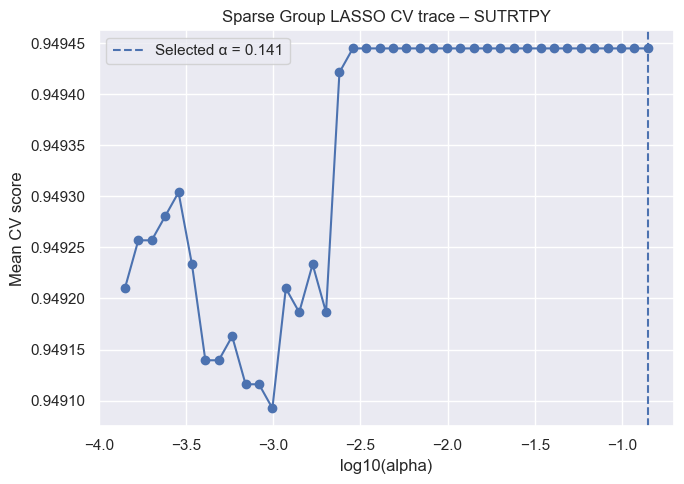

Saved CV trace plot to: ../output_reports\SUTRTPY\sgl_output\sgl_cv_trace.png


In [ ]:
alphas = np.array(sgl.alphas_)          
scores_path = np.array(sgl.scoring_path_)  

if scores_path.shape[0] == alphas.shape[0]:
    # rows = alphas, columns = folds
    mean_scores = scores_path.mean(axis=1)
elif scores_path.shape[1] == alphas.shape[0]:
    # columns = alphas, rows = folds
    mean_scores = scores_path.mean(axis=0)
else:
    raise ValueError(
        f"Unexpected scoring_path_ shape {scores_path.shape} "
        f"for {alphas.shape[0]} alphas."
    )

# 3) Plot trace
plt.figure(figsize=(7, 5))
plt.plot(np.log10(alphas), mean_scores, marker="o")
plt.axvline(np.log10(sgl.alpha_), linestyle="--", label=f"Selected α = {sgl.alpha_:.3g}")
plt.xlabel("log10(alpha)")
plt.ylabel("Mean CV score")
plt.title("Sparse Group LASSO CV trace - SUTRTPY")
plt.legend()
plt.tight_layout()

trace_path = os.path.join(sgl_dir, "sgl_cv_trace.png")
plt.savefig(trace_path, dpi=200)
plt.show()

In [ ]:
print(sgl.__class__)
print(sorted(sgl.__dict__.keys()))

<class 'groupyr.logistic.LogisticSGLCV'>
['alpha_', 'alphas', 'alphas_', 'bayes_optimizer_', 'classes_', 'coef_', 'copy_X', 'cv', 'eps', 'fit_intercept', 'groups', 'intercept_', 'is_fitted_', 'l1_ratio', 'l1_ratio_', 'max_iter', 'n_alphas', 'n_bayes_iter', 'n_bayes_points', 'n_features_in_', 'n_iter_', 'n_jobs', 'normalize', 'random_state', 'scale_l2_by', 'scoring', 'scoring_path_', 'suppress_solver_warnings', 'tol', 'tuning_strategy', 'verbose']


5